# imports

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
import pandas as pd
from torch.optim import lr_scheduler
import time
from utils import forward_selection, SI_evaluation

In [2]:
### SETTINGS

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
batch_size = 128
NUM_EPOCHS = 50
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
t = transforms.Compose([
                       transforms.ToTensor()]
                       )

In [4]:
cifar_train = torchvision.datasets.CIFAR10(root = './CIFAR10/' , train = True , download = True , transform = t)
cifar_split = torchvision.datasets.CIFAR10(root = './CIFAR10/' , train = False , download = True , transform = t)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
torch.manual_seed(42)
cifar_val,cifar_test = random_split(cifar_split,(6700,3300))

In [6]:
train_loader = DataLoader(cifar_train,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 4)
val_loader = DataLoader(cifar_val,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)
test_loader = DataLoader(cifar_test,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)

# model

In [7]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :32, :32]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(256, 200)
        self.z_log_var = torch.nn.Linear(256, 200)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 256),
                Reshape(-1, 64, 2, 2),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        #print(x.shape)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [8]:
model = VAE().cuda(3)

In [9]:
test = torch.Tensor(1,3, 32,32)
test = test.cuda(3)

In [10]:
a, b, c, d = model(test)
d.shape

torch.Size([1, 3, 32, 32])

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  


In [12]:
def train_vae_v1(num_epochs, model, optimizer, device, 
                 train_loader, loss_fn=None,
                 logging_interval=100, 
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)
            
            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + 
            #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension
    
            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension
            
            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict

In [134]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device='cuda:1', 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50,
                        save_model='vae_cifar_02.pt')

Epoch: 001/050 | Batch 0000/0391 | Loss: 324.4150
Epoch: 001/050 | Batch 0050/0391 | Loss: 186.1370
Epoch: 001/050 | Batch 0100/0391 | Loss: 157.3741
Epoch: 001/050 | Batch 0150/0391 | Loss: 139.3762
Epoch: 001/050 | Batch 0200/0391 | Loss: 126.6100
Epoch: 001/050 | Batch 0250/0391 | Loss: 126.9593
Epoch: 001/050 | Batch 0300/0391 | Loss: 122.6603
Epoch: 001/050 | Batch 0350/0391 | Loss: 122.7794
Time elapsed: 0.09 min
Epoch: 002/050 | Batch 0000/0391 | Loss: 122.7438
Epoch: 002/050 | Batch 0050/0391 | Loss: 112.0841
Epoch: 002/050 | Batch 0100/0391 | Loss: 128.2988
Epoch: 002/050 | Batch 0150/0391 | Loss: 116.3561
Epoch: 002/050 | Batch 0200/0391 | Loss: 123.0654
Epoch: 002/050 | Batch 0250/0391 | Loss: 114.7315
Epoch: 002/050 | Batch 0300/0391 | Loss: 111.0665
Epoch: 002/050 | Batch 0350/0391 | Loss: 109.7571
Time elapsed: 0.17 min
Epoch: 003/050 | Batch 0000/0391 | Loss: 106.1844
Epoch: 003/050 | Batch 0050/0391 | Loss: 110.1473
Epoch: 003/050 | Batch 0100/0391 | Loss: 101.4025
Epoc

In [210]:
PATH = 'model/model_VAE_cifar.pth'
torch.save(model.state_dict(), PATH)

In [13]:
PATH = 'model/model_VAE_cifar.pth'
model=VAE().cuda(3)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [14]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

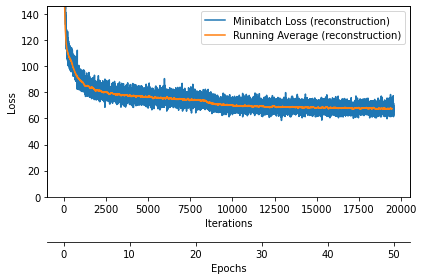

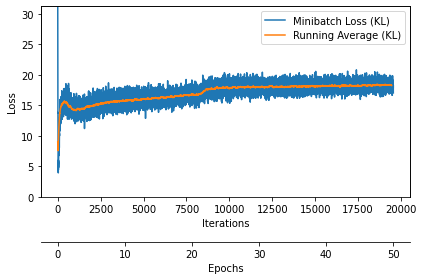

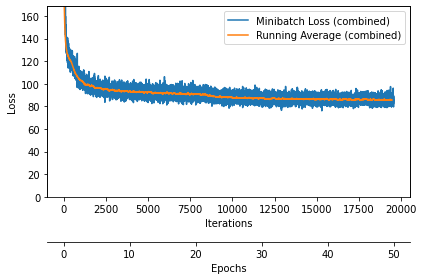

In [137]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

In [28]:
def plot_generated_images(data_loader, model, device, 
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        
        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')
                
                

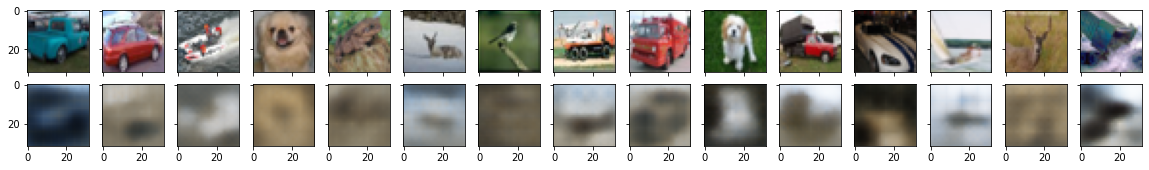

In [140]:
#unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
plot_generated_images(data_loader=train_loader,
                      model=model,
                      #unnormalizer=unnormalizer,
                      device='cuda:1',
                      modeltype='VAE')      

In [15]:
def plot_images_sampled_from_vae(model, device, latent_size, unnormalizer=None, num_images=10):

    with torch.no_grad():

        ##########################
        ### RANDOM SAMPLE
        ##########################    

        rand_features = torch.randn(num_images, latent_size).to(device)
        new_images = model.decoder(rand_features)
        color_channels = new_images.shape[1]
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        ##########################
        ### VISUALIZATION
        ##########################

        image_width = 28

        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary') 

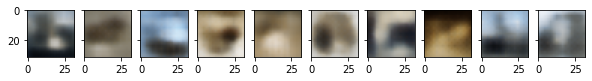

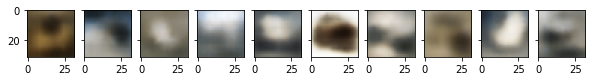

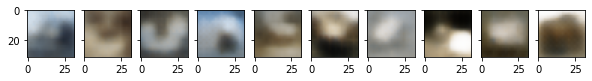

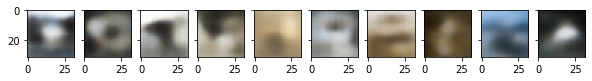

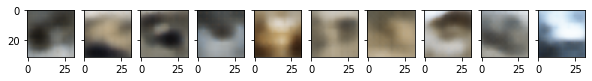

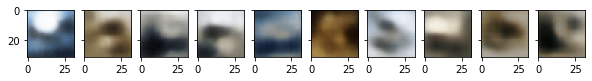

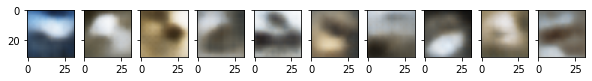

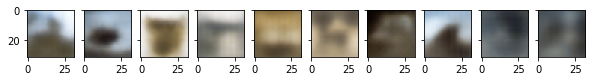

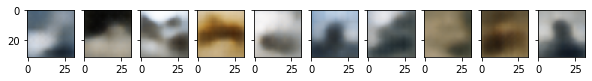

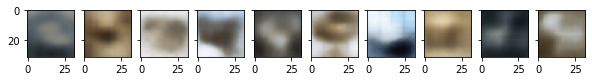

In [16]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device='cuda:3', latent_size=200)
    plt.show()

In [176]:
j = 24
features[j*128:(j)*128+100,:].shape

torch.Size([100, 256])

In [17]:
device = 'cuda:3'
model = model.to(device)
features = torch.zeros([10000, 256], device = 'cuda:3')
labels = torch.zeros([10000,],device = 'cuda:3')

for batch_idx, (X, y) in enumerate(test_loader):
    with torch.no_grad():
            X = X.to(device)
            y = y.to(device)

            feature = model.encoder(X)
            if batch_idx<25:
                features[batch_idx*128:(batch_idx+1)*128,:] = feature
                labels[batch_idx*128:(batch_idx+1)*128] = y
            else:
                features[batch_idx*128:(batch_idx)*128+100,:] = feature
                labels[batch_idx*128:(batch_idx)*128+100] = y
                

In [18]:
f, sis = forward_selection(features, labels,n = 100)#embedding, label, 100

  0%|          | 0/256 [00:00<?, ?it/s]

best SI:0.7089999914169312 for 101


  0%|          | 0/255 [00:00<?, ?it/s]

best SI:0.7178999781608582 for 54


  0%|          | 0/254 [00:00<?, ?it/s]

best SI:0.7203999757766724 for 102


  0%|          | 0/253 [00:00<?, ?it/s]

best SI:0.7240999937057495 for 235


  0%|          | 0/252 [00:00<?, ?it/s]

best SI:0.7260000109672546 for 52


  0%|          | 0/251 [00:00<?, ?it/s]

best SI:0.7297999858856201 for 111


  0%|          | 0/250 [00:00<?, ?it/s]

best SI:0.7318999767303467 for 194


  0%|          | 0/249 [00:00<?, ?it/s]

best SI:0.7339999675750732 for 7


  0%|          | 0/248 [00:00<?, ?it/s]

best SI:0.7368999719619751 for 103


  0%|          | 0/247 [00:00<?, ?it/s]

best SI:0.7375999689102173 for 165


  0%|          | 0/246 [00:00<?, ?it/s]

best SI:0.738599956035614 for 71


  0%|          | 0/245 [00:00<?, ?it/s]

best SI:0.7390999794006348 for 192


  0%|          | 0/244 [00:00<?, ?it/s]

best SI:0.740399956703186 for 91


  0%|          | 0/243 [00:00<?, ?it/s]

best SI:0.7421999573707581 for 53


  0%|          | 0/242 [00:00<?, ?it/s]

best SI:0.7419999837875366 for 158


  0%|          | 0/241 [00:00<?, ?it/s]

best SI:0.7419999837875366 for 128


  0%|          | 0/240 [00:00<?, ?it/s]

best SI:0.7427999973297119 for 171


  0%|          | 0/239 [00:00<?, ?it/s]

best SI:0.7422999739646912 for 236


  0%|          | 0/238 [00:00<?, ?it/s]

best SI:0.7434999942779541 for 183


  0%|          | 0/237 [00:00<?, ?it/s]

best SI:0.7437999844551086 for 153


  0%|          | 0/236 [00:00<?, ?it/s]

best SI:0.7440999746322632 for 182


  0%|          | 0/235 [00:00<?, ?it/s]

best SI:0.7448999881744385 for 160


  0%|          | 0/234 [00:00<?, ?it/s]

best SI:0.7455999851226807 for 213


  0%|          | 0/233 [00:00<?, ?it/s]

best SI:0.7461000084877014 for 117


  0%|          | 0/232 [00:00<?, ?it/s]

best SI:0.7468999624252319 for 59


  0%|          | 0/231 [00:00<?, ?it/s]

best SI:0.7468000054359436 for 116


  0%|          | 0/230 [00:00<?, ?it/s]

best SI:0.7466999888420105 for 122


  0%|          | 0/229 [00:00<?, ?it/s]

best SI:0.7472999691963196 for 120


  0%|          | 0/228 [00:00<?, ?it/s]

best SI:0.7465999722480774 for 65


  0%|          | 0/227 [00:00<?, ?it/s]

best SI:0.7464999556541443 for 141


  0%|          | 0/226 [00:00<?, ?it/s]

best SI:0.7498999834060669 for 90


  0%|          | 0/225 [00:00<?, ?it/s]

best SI:0.7501999735832214 for 19


  0%|          | 0/224 [00:00<?, ?it/s]

best SI:0.7498999834060669 for 44


  0%|          | 0/223 [00:00<?, ?it/s]

best SI:0.7495999932289124 for 69


  0%|          | 0/222 [00:00<?, ?it/s]

best SI:0.7504000067710876 for 241


  0%|          | 0/221 [00:00<?, ?it/s]

best SI:0.7507999539375305 for 100


  0%|          | 0/220 [00:00<?, ?it/s]

best SI:0.7513999938964844 for 186


  0%|          | 0/219 [00:00<?, ?it/s]

best SI:0.7512999773025513 for 2


  0%|          | 0/218 [00:00<?, ?it/s]

best SI:0.7507999539375305 for 224


  0%|          | 0/217 [00:00<?, ?it/s]

best SI:0.7502999901771545 for 214


  0%|          | 0/216 [00:00<?, ?it/s]

best SI:0.7494999766349792 for 30


  0%|          | 0/215 [00:00<?, ?it/s]

best SI:0.7501999735832214 for 0


  0%|          | 0/214 [00:00<?, ?it/s]

best SI:0.7520999908447266 for 161


  0%|          | 0/213 [00:00<?, ?it/s]

best SI:0.7519999742507935 for 222


  0%|          | 0/212 [00:00<?, ?it/s]

best SI:0.7513999938964844 for 64


  0%|          | 0/211 [00:00<?, ?it/s]

best SI:0.7523999810218811 for 166


  0%|          | 0/210 [00:00<?, ?it/s]

best SI:0.7526999711990356 for 38


  0%|          | 0/209 [00:00<?, ?it/s]

best SI:0.7532999515533447 for 67


  0%|          | 0/208 [00:00<?, ?it/s]

best SI:0.7538999915122986 for 45


  0%|          | 0/207 [00:00<?, ?it/s]

best SI:0.7536999583244324 for 74


  0%|          | 0/206 [00:00<?, ?it/s]

best SI:0.7530999779701233 for 126


  0%|          | 0/205 [00:00<?, ?it/s]

best SI:0.7526999711990356 for 162


  0%|          | 0/204 [00:00<?, ?it/s]

best SI:0.7531999945640564 for 33


  0%|          | 0/203 [00:00<?, ?it/s]

best SI:0.7537999749183655 for 184


  0%|          | 0/202 [00:00<?, ?it/s]

best SI:0.7534999847412109 for 249


  0%|          | 0/201 [00:00<?, ?it/s]

best SI:0.7541999816894531 for 226


  0%|          | 0/200 [00:00<?, ?it/s]

best SI:0.7542999982833862 for 80


  0%|          | 0/199 [00:00<?, ?it/s]

best SI:0.7541999816894531 for 181


  0%|          | 0/198 [00:00<?, ?it/s]

best SI:0.7547000050544739 for 68


  0%|          | 0/197 [00:00<?, ?it/s]

best SI:0.7550999522209167 for 130


  0%|          | 0/196 [00:00<?, ?it/s]

best SI:0.7556999921798706 for 242


  0%|          | 0/195 [00:00<?, ?it/s]

best SI:0.7556999921798706 for 26


  0%|          | 0/194 [00:00<?, ?it/s]

best SI:0.7556999921798706 for 94


  0%|          | 0/193 [00:00<?, ?it/s]

best SI:0.7554999589920044 for 199


  0%|          | 0/192 [00:00<?, ?it/s]

best SI:0.7561999559402466 for 72


  0%|          | 0/191 [00:00<?, ?it/s]

best SI:0.755899965763092 for 85


  0%|          | 0/190 [00:00<?, ?it/s]

best SI:0.7551999688148499 for 152


  0%|          | 0/189 [00:00<?, ?it/s]

best SI:0.7544999718666077 for 40


  0%|          | 0/188 [00:00<?, ?it/s]

best SI:0.7544999718666077 for 187


  0%|          | 0/187 [00:00<?, ?it/s]

best SI:0.7542999982833862 for 204


  0%|          | 0/186 [00:00<?, ?it/s]

best SI:0.75409996509552 for 29


  0%|          | 0/185 [00:00<?, ?it/s]

best SI:0.7542999982833862 for 157


  0%|          | 0/184 [00:00<?, ?it/s]

best SI:0.7544999718666077 for 229


  0%|          | 0/183 [00:00<?, ?it/s]

best SI:0.7541999816894531 for 202


  0%|          | 0/182 [00:00<?, ?it/s]

best SI:0.7536999583244324 for 190


  0%|          | 0/181 [00:00<?, ?it/s]

best SI:0.7534999847412109 for 3


  0%|          | 0/180 [00:00<?, ?it/s]

best SI:0.7537999749183655 for 17


  0%|          | 0/179 [00:00<?, ?it/s]

best SI:0.7538999915122986 for 89


  0%|          | 0/178 [00:00<?, ?it/s]

best SI:0.7533999681472778 for 15


  0%|          | 0/177 [00:00<?, ?it/s]

best SI:0.7536999583244324 for 255


  0%|          | 0/176 [00:00<?, ?it/s]

best SI:0.7540000081062317 for 42


  0%|          | 0/175 [00:00<?, ?it/s]

best SI:0.7536999583244324 for 20


  0%|          | 0/174 [00:00<?, ?it/s]

best SI:0.7540000081062317 for 36


  0%|          | 0/173 [00:00<?, ?it/s]

best SI:0.753600001335144 for 131


  0%|          | 0/172 [00:00<?, ?it/s]

best SI:0.7538999915122986 for 228


  0%|          | 0/171 [00:00<?, ?it/s]

best SI:0.753600001335144 for 172


  0%|          | 0/170 [00:00<?, ?it/s]

best SI:0.753600001335144 for 125


  0%|          | 0/169 [00:00<?, ?it/s]

best SI:0.7534999847412109 for 12


  0%|          | 0/168 [00:00<?, ?it/s]

best SI:0.7531999945640564 for 34


  0%|          | 0/167 [00:00<?, ?it/s]

best SI:0.7530999779701233 for 254


  0%|          | 0/166 [00:00<?, ?it/s]

best SI:0.7533999681472778 for 133


  0%|          | 0/165 [00:00<?, ?it/s]

best SI:0.7532999515533447 for 150


  0%|          | 0/164 [00:00<?, ?it/s]

best SI:0.7533999681472778 for 215


  0%|          | 0/163 [00:00<?, ?it/s]

best SI:0.7547000050544739 for 95


  0%|          | 0/162 [00:00<?, ?it/s]

best SI:0.7547999620437622 for 5


  0%|          | 0/161 [00:00<?, ?it/s]

best SI:0.75409996509552 for 62


  0%|          | 0/160 [00:00<?, ?it/s]

best SI:0.7537999749183655 for 14


  0%|          | 0/159 [00:00<?, ?it/s]

best SI:0.7532999515533447 for 76


  0%|          | 0/158 [00:00<?, ?it/s]

best SI:0.7530999779701233 for 143


  0%|          | 0/157 [00:00<?, ?it/s]

best SI:0.7532999515533447 for 145


  0%|          | 0/156 [00:00<?, ?it/s]

best SI:0.7531999945640564 for 35
best features obtaied


([101,
  54,
  102,
  235,
  52,
  111,
  194,
  7,
  103,
  165,
  71,
  192,
  91,
  53,
  158,
  128,
  171,
  236,
  183,
  153,
  182,
  160,
  213,
  117,
  59,
  116,
  122,
  120,
  65,
  141,
  90,
  19,
  44,
  69,
  241,
  100,
  186,
  2,
  224,
  214,
  30,
  0,
  161,
  222,
  64,
  166,
  38,
  67,
  45,
  74,
  126,
  162,
  33,
  184,
  249,
  226,
  80,
  181,
  68,
  130,
  242,
  26,
  94,
  199,
  72,
  85,
  152,
  40,
  187,
  204,
  29,
  157,
  229,
  202,
  190,
  3,
  17,
  89,
  15,
  255,
  42,
  20,
  36,
  131,
  228,
  172,
  125,
  12,
  34,
  254,
  133,
  150,
  215,
  95,
  5,
  62,
  14,
  76,
  143,
  145],
 [0.7089999914169312,
  0.7178999781608582,
  0.7203999757766724,
  0.7240999937057495,
  0.7260000109672546,
  0.7297999858856201,
  0.7318999767303467,
  0.7339999675750732,
  0.7368999719619751,
  0.7375999689102173,
  0.738599956035614,
  0.7390999794006348,
  0.740399956703186,
  0.7421999573707581,
  0.7419999837875366,
  0.741999983787536

In [20]:
f, sis = forward_selection(features, labels,n = 100)#embedding, label, 100

  0%|          | 0/256 [00:00<?, ?it/s]

best SI:0.7089999914169312 for 101


  0%|          | 0/255 [00:00<?, ?it/s]

best SI:0.7178999781608582 for 54


  0%|          | 0/254 [00:00<?, ?it/s]

best SI:0.7203999757766724 for 102


  0%|          | 0/253 [00:00<?, ?it/s]

best SI:0.7240999937057495 for 235


  0%|          | 0/252 [00:00<?, ?it/s]

best SI:0.7260000109672546 for 52


  0%|          | 0/251 [00:00<?, ?it/s]

best SI:0.7297999858856201 for 111


  0%|          | 0/250 [00:00<?, ?it/s]

best SI:0.7318999767303467 for 194


  0%|          | 0/249 [00:00<?, ?it/s]

best SI:0.7339999675750732 for 7


  0%|          | 0/248 [00:00<?, ?it/s]

best SI:0.7368999719619751 for 103


  0%|          | 0/247 [00:00<?, ?it/s]

best SI:0.7375999689102173 for 165


  0%|          | 0/246 [00:00<?, ?it/s]

best SI:0.738599956035614 for 71


  0%|          | 0/245 [00:00<?, ?it/s]

best SI:0.7390999794006348 for 192


  0%|          | 0/244 [00:00<?, ?it/s]

best SI:0.740399956703186 for 91


  0%|          | 0/243 [00:00<?, ?it/s]

best SI:0.7421999573707581 for 53


  0%|          | 0/242 [00:00<?, ?it/s]

best SI:0.7419999837875366 for 158


  0%|          | 0/241 [00:00<?, ?it/s]

best SI:0.7419999837875366 for 128


  0%|          | 0/240 [00:00<?, ?it/s]

best SI:0.7427999973297119 for 171


  0%|          | 0/239 [00:00<?, ?it/s]

best SI:0.7422999739646912 for 236


  0%|          | 0/238 [00:00<?, ?it/s]

best SI:0.7434999942779541 for 183


  0%|          | 0/237 [00:00<?, ?it/s]

best SI:0.7437999844551086 for 153


  0%|          | 0/236 [00:00<?, ?it/s]

best SI:0.7440999746322632 for 182


  0%|          | 0/235 [00:00<?, ?it/s]

best SI:0.7448999881744385 for 160


  0%|          | 0/234 [00:00<?, ?it/s]

best SI:0.7455999851226807 for 213


  0%|          | 0/233 [00:00<?, ?it/s]

best SI:0.7461000084877014 for 117


  0%|          | 0/232 [00:00<?, ?it/s]

best SI:0.7468999624252319 for 59


  0%|          | 0/231 [00:00<?, ?it/s]

best SI:0.7468000054359436 for 116


  0%|          | 0/230 [00:00<?, ?it/s]

best SI:0.7466999888420105 for 122


  0%|          | 0/229 [00:00<?, ?it/s]

best SI:0.7472999691963196 for 120


  0%|          | 0/228 [00:00<?, ?it/s]

best SI:0.7465999722480774 for 65


  0%|          | 0/227 [00:00<?, ?it/s]

best SI:0.7464999556541443 for 141


  0%|          | 0/226 [00:00<?, ?it/s]

best SI:0.7498999834060669 for 90


  0%|          | 0/225 [00:00<?, ?it/s]

best SI:0.7501999735832214 for 19


  0%|          | 0/224 [00:00<?, ?it/s]

best SI:0.7498999834060669 for 44


  0%|          | 0/223 [00:00<?, ?it/s]

best SI:0.7495999932289124 for 69


  0%|          | 0/222 [00:00<?, ?it/s]

best SI:0.7504000067710876 for 241


  0%|          | 0/221 [00:00<?, ?it/s]

best SI:0.7507999539375305 for 100


  0%|          | 0/220 [00:00<?, ?it/s]

best SI:0.7513999938964844 for 186


  0%|          | 0/219 [00:00<?, ?it/s]

best SI:0.7512999773025513 for 2


  0%|          | 0/218 [00:00<?, ?it/s]

best SI:0.7507999539375305 for 224


  0%|          | 0/217 [00:00<?, ?it/s]

best SI:0.7502999901771545 for 214


  0%|          | 0/216 [00:00<?, ?it/s]

best SI:0.7494999766349792 for 30


  0%|          | 0/215 [00:00<?, ?it/s]

best SI:0.7501999735832214 for 0


  0%|          | 0/214 [00:00<?, ?it/s]

best SI:0.7520999908447266 for 161


  0%|          | 0/213 [00:00<?, ?it/s]

best SI:0.7519999742507935 for 222


  0%|          | 0/212 [00:00<?, ?it/s]

best SI:0.7513999938964844 for 64


  0%|          | 0/211 [00:00<?, ?it/s]

best SI:0.7523999810218811 for 166


  0%|          | 0/210 [00:00<?, ?it/s]

best SI:0.7526999711990356 for 38


  0%|          | 0/209 [00:00<?, ?it/s]

best SI:0.7532999515533447 for 67


  0%|          | 0/208 [00:00<?, ?it/s]

best SI:0.7538999915122986 for 45


  0%|          | 0/207 [00:00<?, ?it/s]

best SI:0.7536999583244324 for 74


  0%|          | 0/206 [00:00<?, ?it/s]

best SI:0.7530999779701233 for 126


  0%|          | 0/205 [00:00<?, ?it/s]

best SI:0.7526999711990356 for 162


  0%|          | 0/204 [00:00<?, ?it/s]

best SI:0.7531999945640564 for 33


  0%|          | 0/203 [00:00<?, ?it/s]

best SI:0.7537999749183655 for 184


  0%|          | 0/202 [00:00<?, ?it/s]

best SI:0.7534999847412109 for 249


  0%|          | 0/201 [00:00<?, ?it/s]

best SI:0.7541999816894531 for 226


  0%|          | 0/200 [00:00<?, ?it/s]

best SI:0.7542999982833862 for 80


  0%|          | 0/199 [00:00<?, ?it/s]

best SI:0.7541999816894531 for 181


  0%|          | 0/198 [00:00<?, ?it/s]

best SI:0.7547000050544739 for 68


  0%|          | 0/197 [00:00<?, ?it/s]

best SI:0.7550999522209167 for 130


  0%|          | 0/196 [00:00<?, ?it/s]

best SI:0.7556999921798706 for 242


  0%|          | 0/195 [00:00<?, ?it/s]

best SI:0.7556999921798706 for 26


  0%|          | 0/194 [00:00<?, ?it/s]

best SI:0.7556999921798706 for 94


  0%|          | 0/193 [00:00<?, ?it/s]

best SI:0.7554999589920044 for 199


  0%|          | 0/192 [00:00<?, ?it/s]

best SI:0.7561999559402466 for 72


  0%|          | 0/191 [00:00<?, ?it/s]

best SI:0.755899965763092 for 85


  0%|          | 0/190 [00:00<?, ?it/s]

best SI:0.7551999688148499 for 152


  0%|          | 0/189 [00:00<?, ?it/s]

best SI:0.7544999718666077 for 40


  0%|          | 0/188 [00:00<?, ?it/s]

best SI:0.7544999718666077 for 187


  0%|          | 0/187 [00:00<?, ?it/s]

best SI:0.7542999982833862 for 204


  0%|          | 0/186 [00:00<?, ?it/s]

best SI:0.75409996509552 for 29


  0%|          | 0/185 [00:00<?, ?it/s]

best SI:0.7542999982833862 for 157


  0%|          | 0/184 [00:00<?, ?it/s]

best SI:0.7544999718666077 for 229


  0%|          | 0/183 [00:00<?, ?it/s]

best SI:0.7541999816894531 for 202


  0%|          | 0/182 [00:00<?, ?it/s]

best SI:0.7536999583244324 for 190


  0%|          | 0/181 [00:00<?, ?it/s]

best SI:0.7534999847412109 for 3


  0%|          | 0/180 [00:00<?, ?it/s]

best SI:0.7537999749183655 for 17


  0%|          | 0/179 [00:00<?, ?it/s]

best SI:0.7538999915122986 for 89


  0%|          | 0/178 [00:00<?, ?it/s]

best SI:0.7533999681472778 for 15


  0%|          | 0/177 [00:00<?, ?it/s]

best SI:0.7536999583244324 for 255


  0%|          | 0/176 [00:00<?, ?it/s]

best SI:0.7540000081062317 for 42


  0%|          | 0/175 [00:00<?, ?it/s]

best SI:0.7536999583244324 for 20


  0%|          | 0/174 [00:00<?, ?it/s]

best SI:0.7540000081062317 for 36


  0%|          | 0/173 [00:00<?, ?it/s]

best SI:0.753600001335144 for 131


  0%|          | 0/172 [00:00<?, ?it/s]

best SI:0.7538999915122986 for 228


  0%|          | 0/171 [00:00<?, ?it/s]

best SI:0.753600001335144 for 172


  0%|          | 0/170 [00:00<?, ?it/s]

best SI:0.753600001335144 for 125


  0%|          | 0/169 [00:00<?, ?it/s]

best SI:0.7534999847412109 for 12


  0%|          | 0/168 [00:00<?, ?it/s]

best SI:0.7531999945640564 for 34


  0%|          | 0/167 [00:00<?, ?it/s]

best SI:0.7530999779701233 for 254


  0%|          | 0/166 [00:00<?, ?it/s]

best SI:0.7533999681472778 for 133


  0%|          | 0/165 [00:00<?, ?it/s]

best SI:0.7532999515533447 for 150


  0%|          | 0/164 [00:00<?, ?it/s]

best SI:0.7533999681472778 for 215


  0%|          | 0/163 [00:00<?, ?it/s]

best SI:0.7547000050544739 for 95


  0%|          | 0/162 [00:00<?, ?it/s]

best SI:0.7547999620437622 for 5


  0%|          | 0/161 [00:00<?, ?it/s]

best SI:0.75409996509552 for 62


  0%|          | 0/160 [00:00<?, ?it/s]

best SI:0.7537999749183655 for 14


  0%|          | 0/159 [00:00<?, ?it/s]

best SI:0.7532999515533447 for 76


  0%|          | 0/158 [00:00<?, ?it/s]

best SI:0.7530999779701233 for 143


  0%|          | 0/157 [00:00<?, ?it/s]

best SI:0.7532999515533447 for 145


  0%|          | 0/156 [00:00<?, ?it/s]

best SI:0.7531999945640564 for 35
best features obtaied


In [29]:
SI_evaluation(features, labels)

tensor(0.7404, device='cuda:3')

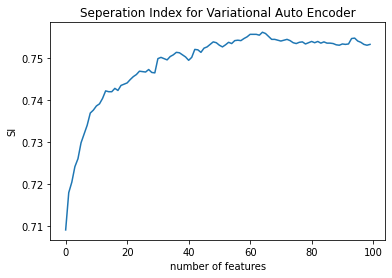

In [26]:
plt.plot(sis)
plt.title("Seperation Index for Variational Auto Encoder")
plt.ylabel('SI')
plt.xlabel('number of features');